In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import time
import _transientsv3 as _trans

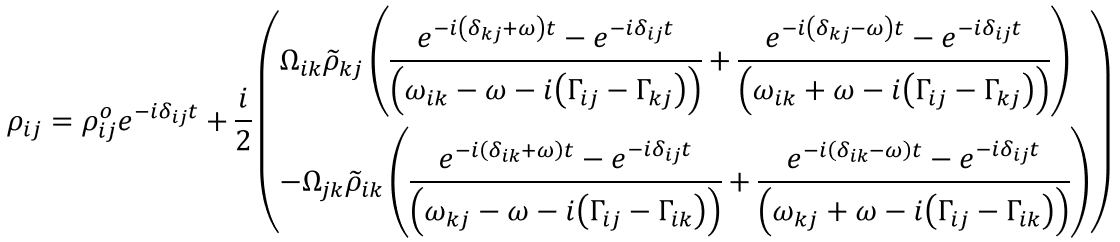

In [2]:
# useful constants
c = 2.998e8 # in m/s

In [3]:
# modeling functions

hs = lambda x: np.heaviside(x, 1)

delta_ij = lambda omega_ij, gamma_ij: omega_ij-1J*gamma_ij

pulse = lambda ti, tf, t: hs(t-ti)-hs(t-tf)

def fid(rho0_ij, 
        #rho_prev, 
        delta_ij, 
        t):
    return rho0_ij*np.exp(-1J*delta_ij*t)

def ket_abs(rabi_ik, 
            #rho_kj, 
            delta_kj, 
            delta_ij, 
            omega, 
            omega_ik, 
            gamma_ij, 
            gamma_kj, 
            t):
    rho_ij = 1J/2*rabi_ik*((np.exp(-1J*(delta_kj+omega)*t)-np.exp(-1J*(delta_ij)*t))
                                  /(omega_ik-omega-1J*(gamma_ij-gamma_kj)))
    return rho_ij

def ket_emis(rabi_ik, 
             #rho_kj, 
             delta_kj, 
             delta_ij, 
             omega, 
             omega_ik, 
             gamma_ij, 
             gamma_kj, 
             t):
    rho_ij = 1J/2*rabi_ik*rho_kj*((np.exp(-1J*(delta_kj-omega)*t)-np.exp(-1J*(delta_ij)*t))
                                  /(omega_ik+omega-1J*(gamma_ij-gamma_kj)))
    return rho_ij

def bra_abs(rabi_jk, 
            #rho_ik, 
            delta_ik, 
            delta_ij, 
            omega, 
            omega_kj, 
            gamma_ij, 
            gamma_ik, 
            t):
    rho_ij = -1J/2*rabi_jk*((np.exp(-1J*(delta_ik+omega)*t)-np.exp(-1J*(delta_ij)*t))
                                  /(omega_kj-omega-1J*(gamma_ij-gamma_ik)))
    return rho_ij

def bra_emis(rabi_jk, 
             #rho_ik, 
             delta_ik, 
             delta_ij,
             omega, 
             omega_kj, 
             gamma_ij, 
             gamma_ik, 
             t):
    return -1J/2*rabi_jk*((np.exp(-1J*(delta_ik-omega)*t)-np.exp(-1J*(delta_ij)*t))
                                  /(omega_kj+omega-1J*(gamma_ij-gamma_ik)))






The intensity is 0.0007038618639566876
calc. time was 1.79s.


(0.0, 1.4599999999999998e-12)

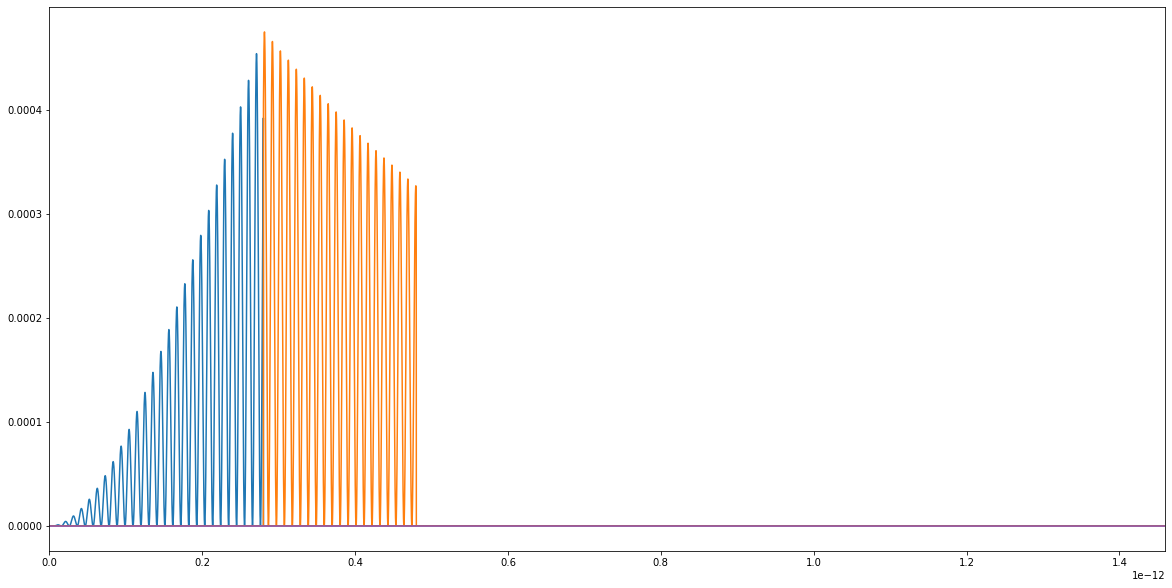

In [4]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,10)

# Test script
omega_trans = [2253,]
omega_l1 = 1600*c*100*2*np.pi
omega_l2 = 2990*c*100*2*np.pi
omega_l3 = 9670*c*100*2*np.pi
gamma_gaval = 5*c*2*np.pi*100
gamma_baval = 8*c*2*np.pi*100
gamma_eaval = 10*c*2*np.pi*100*2

Rabi1 = 2.045e11
Rabi2 = 5.817e10
Rabi3 = 9.933e12

d1 = 200e-15
d2 = 200e-15

pw1 = 280e-15
pw2 = 180e-15
pw3 = 600e-15

t0 = 0
t1 = round(t0+pw1,18)
t2 = t1+d1
t3 = round(t2+pw2,18)
t4 = t3+d2
t5 = t4+pw3
tmax = 2e-12

npts = 1000
t = np.linspace(t0, tmax, int((tmax-t0)*1e15*npts)+1) #always needs extra one for pulse_ends to work!

pulse_ends = [int(i) for i in np.array([t1, t3])*1e15*npts-1]
pulse1 = pulse(t0, t1, t)
pulse2 = pulse(t2, t3, t)
pulse3 = pulse(t4, t5, t)

time1 = time.time()

a = bra_abs(Rabi1, 
            delta_ij(0, 1/1e-12), 
            delta_ij(omega1_trans, gamma_gaval), 
            omega_l1, 
            omega1_trans, 
            gamma_gaval, 
            1/1e-12, 
            t-t0)*pulse1 #trans1, driven, 0 to t1
b = fid(a[pulse_ends[0]], delta_ij(omega1_trans, gamma_gaval), t-t1)*hs(t-t1)
c = ket_abs(Rabi2, 
            delta_ij(omega1_trans, gamma_gaval), 
            delta_ij(omega2_trans, gamma_baval), 
            omega_l2, 
            omega2_trans, 
            gamma_baval, 
            gamma_gaval, 
            t-t2)*pulse2*b
d = fid(c[pulse_ends[1]], delta_ij(omega2_trans, gamma_baval), t-t3)*hs(t-t3)
e = ket_abs(Rabi3, 
            delta_ij(omega2_trans, gamma_baval), 
            delta_ij(omega3_trans, gamma_eaval), 
            omega_l3, 
            omega3_trans, 
            gamma_eaval, 
            gamma_baval, 
            t-t4)*pulse3*d

print(f'The intensity is {np.sum(np.real(e*np.conjugate(e)))}')

time2 = time.time()
print(f'calc. time was {round(time2-time1,2)}s.')

plt.plot(t, np.real(a)**2)
plt.plot(t, np.real(b)**2*pulse(t1,t2,t))
plt.plot(t, np.real(c)**2)
plt.plot(t, np.real(d)**2*pulse(t3,t4,t))
plt.plot(t, np.real(e)**2)
#plt.plot(t, (pulse1+pulse2+pulse3)*max(np.real(a)**2+np.real(c)**2+np.real(e)**2), color='k')

plt.xlim(t0, t5)

In [5]:
time11 = time.time()
T1 = bra_abs(Rabi1, 
             delta_ij(0, 1/1e-12), 
             delta_ij(omega1_trans, gamma_gaval), 
             omega_l1, 
             omega1_trans, 
             gamma_gaval, 
             1/1e-12, 
             t1) #trans1, driven, 0 to t1
FID1 = fid(1, delta_ij(omega1_trans, gamma_gaval), t3-t1)
T2 = ket_abs(Rabi2, 
             delta_ij(omega1_trans, gamma_gaval), 
             delta_ij(omega2_trans, gamma_baval), 
             omega_l2, 
             omega2_trans, 
             gamma_baval, 
             gamma_gaval, 
             t3-t2)
FID2 = fid(1, delta_ij(omega2_trans, gamma_baval), np.linspace(t4, t5, int((t5-t4)*1e15*npts)+1)-t3)
T3 = ket_abs(Rabi3, 
             delta_ij(omega2_trans, gamma_baval), 
             delta_ij(omega3_trans, gamma_eaval), 
             omega_l3, 
             omega3_trans, 
             gamma_eaval, 
             gamma_baval, 
             np.linspace(t4, t5, int((t5-t4)*1e15*npts)+1)-t4)

coeff = T1*FID1*T2
test = np.array(coeff*FID2*T3)

print(f'The intensity is {np.sum(np.real((test*np.conjugate(test))))}')
time22 = time.time()

print(f'calc. time was {round(time22-time11,2)}s.')

The intensity is 0.0007038072755844601
calc. time was 0.21s.
